<a href="https://colab.research.google.com/github/aryan-cs/project-plastic/blob/master/project_plastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Download data from repository

In [ ]:
!wget https://github.com/aryan-cs/project-plastic/archive/refs/heads/master.zip
!unzip master.zip
!rm -rf master.zip

# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

import tensorflow as tf
import os

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

# 2. Remove dodgy images

In [ ]:
import cv2
import imghdr

data_dir = 'project-plastic-master/data'

image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):

    print(image_class)

    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

Found 839 files belonging to 2 classes.


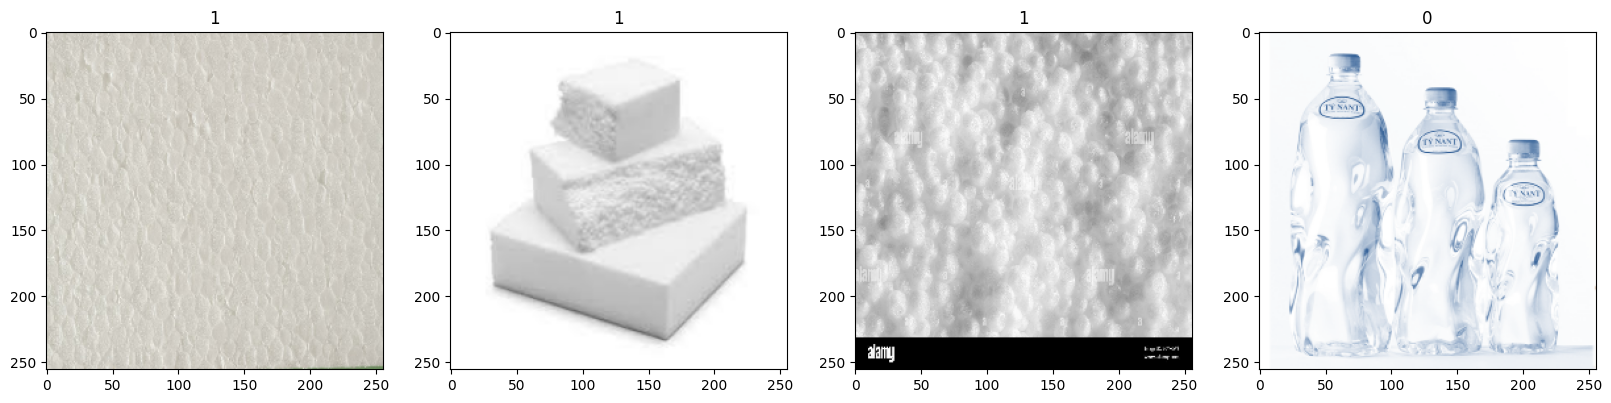

In [5]:
import numpy as np
from matplotlib import pyplot as plt

data = tf.keras.utils.image_dataset_from_directory('project-plastic-master/data')

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [ ]:
data = data.map(lambda x,y: (x/255, y))

data.as_numpy_iterator().next()

# 5. Split Data

In [7]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)

train_size

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [8]:
train

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [9]:
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=16, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/16
21/21 [==============================] - 12s 193ms/step - loss: 0.7556 - accuracy: 0.5298 - val_loss: 0.6020 - val_accuracy: 0.6719
Epoch 2/16
21/21 [==============================] - 6s 254ms/step - loss: 0.4999 - accuracy: 0.7679 - val_loss: 0.4856 - val_accuracy: 0.8281
Epoch 3/16
21/21 [==============================] - 5s 233ms/step - loss: 0.3324 - accuracy: 0.8750 - val_loss: 0.3936 - val_accuracy: 0.8594
Epoch 4/16
21/21 [==============================] - 6s 225ms/step - loss: 0.2754 - accuracy: 0.9062 - val_loss: 0.3926 - val_accuracy: 0.8906
Epoch 5/16
21/21 [==============================] - 6s 246ms/step - loss: 0.2438 - accuracy: 0.9062 - val_loss: 0.1573 - val_accuracy: 0.9219
Epoch 6/16
21/21 [==============================] - 6s 254ms/step - loss: 0.3330 - accuracy: 0.8735 - val_loss: 0.2707 - val_accuracy: 0.9062
Epoch 7/16
21/21 [==============================] - 5s 240ms/step - loss: 0.2012 - accuracy: 0.9182 - val_loss: 0.1613 - val_accuracy: 0.9375
Epoch

# 8. Plot Performance

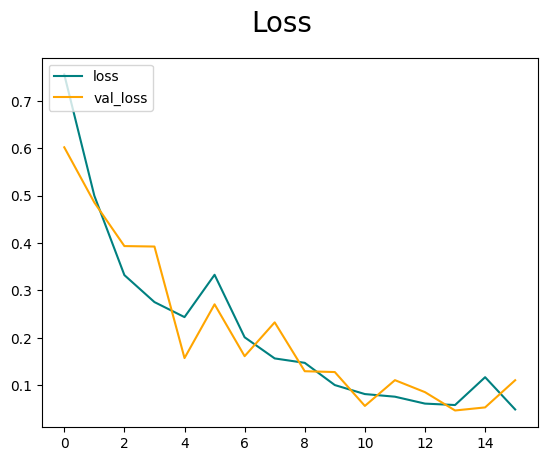

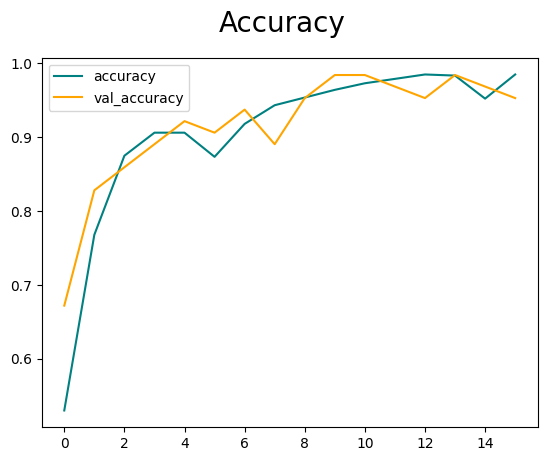

In [10]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [11]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(pre.result(), re.result(), acc.result())

1/1 [==============================] - 0s 48ms/step
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.95, shape=(), dtype=float32) tf.Tensor(0.96875, shape=(), dtype=float32)


# 10. Test

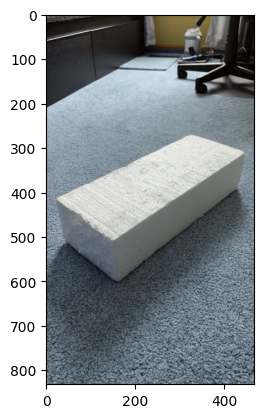

1/1 [==============================] - 0s 34ms/step
I think this is Styrofoam [99.940216]%


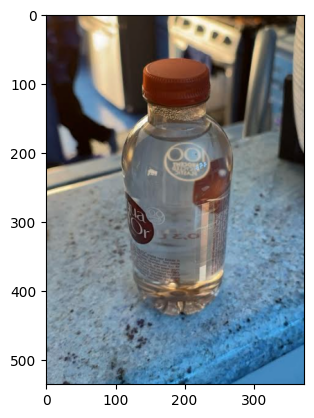

1/1 [==============================] - 0s 30ms/step
I think this is Plastic Bottle [96.722244]%


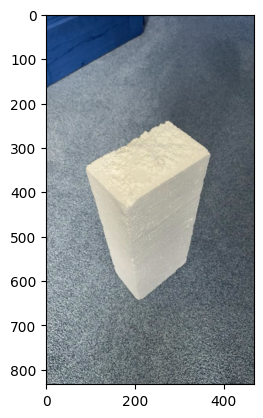

1/1 [==============================] - 0s 27ms/step
I think this is Styrofoam [99.93873]%


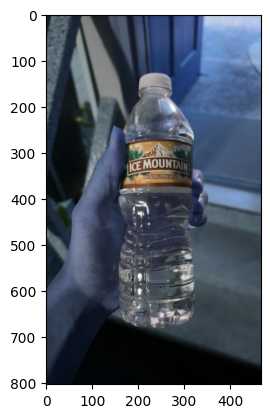

1/1 [==============================] - 0s 21ms/step
I think this is Plastic Bottle [99.999725]%


In [23]:
import cv2

for image in os.listdir("project-plastic-master/tests"):
  image_path = os.path.join("project-plastic-master/tests", image)
  img = cv2.imread(image_path)
  plt.imshow(img)
  plt.show()

  resize = tf.image.resize(img, (256,256))

  yhat = model.predict(np.expand_dims(resize/255, 0))

  # yhat

  if yhat > 0.5:
      print(f'I think this is Styrofoam ' + str(yhat[0] * 100) + '%') # class 1
  else:
      print(f'I think this is Plastic Bottle ' + str(100 - (yhat[0] * 100)) + '%') # class 2

# 11. Save the Model

In [16]:
from tensorflow.keras.models import load_model
from datetime import date

stamp = str(date.today())

model.save(os.path.join('models','plastic-classifier' + stamp + '.h5'))

new_model = load_model('models/plastic-classifier' + stamp + '.h5')

new_model.predict(np.expand_dims(resize/255, 0))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 218ms/step


array([[0.9840406]], dtype=float32)

# 12. Accessing Camera

In [29]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def bbox_to_bytes(bbox_array):
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_stream():
  js = Javascript('''
    var video;
    var width = 640;
    var height = 480;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement1;
    var labelElement2;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement1 = null;
       labelElement2 = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, width, height);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid #1a1a1a00';
      div.style.padding = '10px';
      div.style.width = '50vw';
      div.style.backgroundColor = "#1a1a1a";
      div.style.alignSelf = "stretch";
      div.style.alignItems = "center";
      div.style.borderRadius = '10px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = '<span style="color: black;"></span>';
      labelElement1 = document.createElement('span');
      labelElement1.innerText = 'No data';
      labelElement1.style.color = "red;"
      labelElement1.style.fontSize = "15px";
      modelOut.appendChild(labelElement1);
      div.appendChild(modelOut);

      const prediction = document.createElement('div');
      prediction.innerHTML = '<span style="color: black;"></span>';
      labelElement2 = document.createElement('span');
      labelElement2.innerText = 'No data';
      labelElement2.style.color = "red;"
      labelElement2.style.fontSize = "30px";
      prediction.appendChild(labelElement2);
      div.appendChild(prediction);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 20;
      video.style.marginTop = "10px";
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          '</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = width;
      captureCanvas.height = height;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(status, imgData, prediction) {

      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (status != "") {
        labelElement1.innerHTML = '<span style="color: #e6002e;">' + status + '<br /><br /></span>';
      }

      if (prediction != "") {

        if (prediction == "Styrofoam") {

          labelElement2.innerHTML = '<span style="color: #cfcfcf; font-weight: bold;">' + prediction + '<br /></span>';

        }

        else if (prediction == "Plastic Bottle") {

          labelElement2.innerHTML = '<span style="color: #bafffa; font-weight: bold;">' + prediction + '<br /></span>';

        }

        else  {

          labelElement2.innerHTML = '<span style="color: #474747; font-weight: bold;">' + prediction + '<br /></span>';

        }

      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(statusLabel, bbox, predictionLabel):
  data = eval_js('stream_frame("{}", "{}", "{}")'.format(statusLabel, bbox, predictionLabel))
  return data

video_stream()
status_html = '◉'
prediction_html = "Thinking..."

bbox = ''
count = 0
while True:
    js_reply = video_frame(status_html, bbox, prediction_html)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])
    resize = tf.image.resize(img, (256,256))
    yhat = model.predict(np.expand_dims(resize/255, 0), verbose = 0)

    if yhat > 0.5:
      prediction_html = "Styrofoam " + str(yhat[0] * 100) + "%"
    else:
      prediction_html = "Plastic Bottle " + str(100 - yhat[0] * 100) + "%"

<IPython.core.display.Javascript object>